## SVM

/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor micro-F1 en CV:       0.5238
Mejor Jaccard (samples) en CV: 0.3832
Mejores parámetros (por micro-F1): {'clf__estimator__select__k': 771, 'clf__estimator__svc__C': 0.1, 'clf__estimator__svc__gamma': 0.1}
micro-F1 en validation set:       0.5274
Jaccard (samples) en validation set: 0.3844


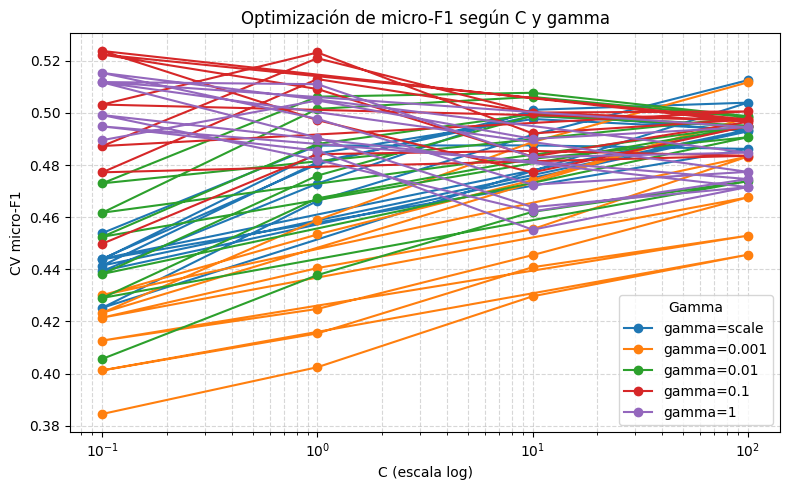

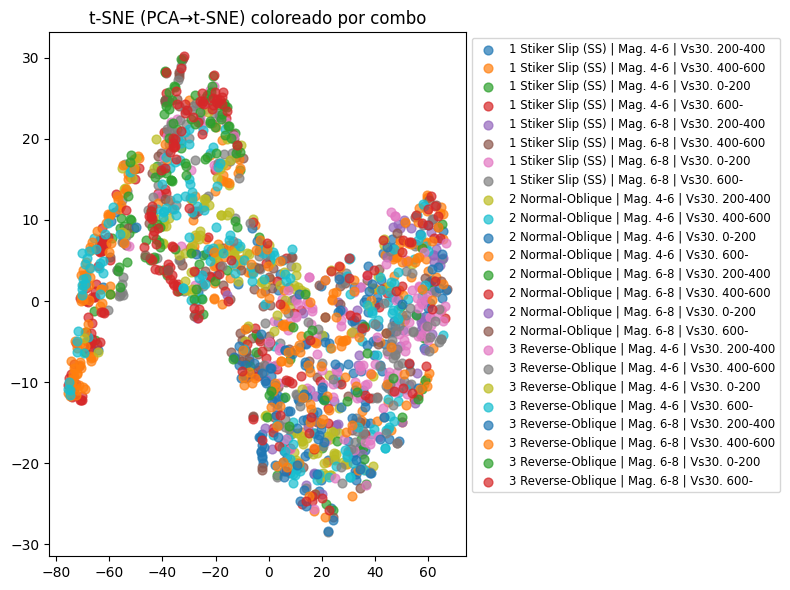


--- Classification Report on TEST ---
              precision    recall  f1-score   support

           0       0.37      0.81      0.51       120
           1       0.25      0.48      0.33        81
           2       0.44      0.62      0.51       139
           3       0.59      0.93      0.72       188
           4       0.68      0.20      0.31       152
           5       0.21      0.69      0.32        42
           6       0.43      0.92      0.58        90
           7       0.38      0.66      0.49       116
           8       0.47      0.71      0.57        92

   micro avg       0.42      0.67      0.51      1020
   macro avg       0.42      0.67      0.48      1020
weighted avg       0.47      0.67      0.50      1020
 samples avg       0.42      0.67      0.51      1020


micro-F1 en TEST:      0.5138
Jaccard (samples) en TEST: 0.3708


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection       import SelectKBest, f_classif
from sklearn.preprocessing          import StandardScaler, OneHotEncoder
from sklearn.svm                    import SVC
from sklearn.multioutput            import MultiOutputClassifier
from sklearn.model_selection        import (
    train_test_split,
    GridSearchCV,
    RepeatedKFold,
    learning_curve
)
from sklearn.pipeline               import Pipeline
from sklearn.manifold               import TSNE
from sklearn.metrics                import (
    classification_report,
    f1_score,
    jaccard_score,
    make_scorer
)

# ——————————————
# carga de datos y split
# ——————————————
X = pd.read_csv('features_fft_eventos.csv')
labels = pd.read_csv('eventos_validos.csv')
labels['combo'] = (
    labels['Tipo de evento'].astype(str) + ' | ' +
    labels['Magnitud'].astype(str)     + ' | ' +
    labels['Vs30'].astype(str)
)

ohe = OneHotEncoder(sparse_output=False)
Y = ohe.fit_transform(labels[['Tipo de evento','Magnitud','Vs30']])

X_temp, X_test, Y_temp, Y_test, _, _ = train_test_split(
    X, Y, labels['combo'],
    test_size=0.20,
    random_state=42,
    stratify=labels['Tipo de evento']
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp,
    test_size=0.25,
    random_state=42,
    stratify=np.argmax(Y_temp, axis=1)
)

# ——————————————
# Pipeline: SelectKBest + SVC dentro de MultiOutputClassifier
# ——————————————
base_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=100)),
    ('svc',    SVC(kernel='rbf', probability=True, class_weight='balanced'))
])

pipeline = Pipeline([
    ('clf', MultiOutputClassifier(base_estimator, n_jobs=-1))
])

# ——————————————
# GridSearchCV 
# ——————————————
param_grid = {
    'clf__estimator__select__k':   [8, 39, 77, 154, 385, 771], # 1% 5% 10% 20% 50% 100%
    'clf__estimator__svc__C':      [0.1, 1, 10, 100],
    'clf__estimator__svc__gamma':  ['scale', 0.001, 0.01, 0.1, 1]
}

# dos metricas apropiadas para multilabel
scoring = {
    'F1_micro':         make_scorer(f1_score,      average='micro'),
    'Jaccard_samples':  make_scorer(jaccard_score, average='samples')
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='F1_micro',   # refit con f1 al mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=False
)

grid.fit(X_train, Y_train)

# resultados CV
best_i = grid.best_index_
print(f"Mejor micro-F1 en CV:       {grid.cv_results_['mean_test_F1_micro'][best_i]:.4f}")
print(f"Mejor Jaccard (samples) en CV: {grid.cv_results_['mean_test_Jaccard_samples'][best_i]:.4f}")
print(f"Mejores parámetros (por micro-F1): {grid.best_params_}")

# ——————————————
# validacion en validation set
# ——————————————
best_model = grid.best_estimator_
Y_val_pred = best_model.predict(X_val)

val_f1_micro  = f1_score(Y_val, Y_val_pred, average='micro')
val_jaccard   = jaccard_score(Y_val, Y_val_pred, average='samples')

print(f"micro-F1 en validation set:       {val_f1_micro:.4f}")
print(f"Jaccard (samples) en validation set: {val_jaccard:.4f}")

# ——————————————
# graficar gamma vs C
# ——————————————
# convertimos cv_results_ a DataFrame
results = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8, 5))
for gamma in sorted(results['param_clf__estimator__svc__gamma'].unique(), 
                    key=lambda x: (str(x)!='scale', float(x) if x!='scale' else -1)):
    mask = results['param_clf__estimator__svc__gamma'] == gamma
    Cs   = results.loc[mask, 'param_clf__estimator__svc__C'].astype(float)
    f1s  = results.loc[mask, 'mean_test_F1_micro']  # explicito micro-F1
    plt.semilogx(Cs, f1s, marker='o', label=f'gamma={gamma}')

plt.xlabel('C (escala log)')
plt.ylabel('CV micro-F1')
plt.title('Optimización de micro-F1 según C y gamma')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title='Gamma')
plt.tight_layout()
plt.show()


# ——————————————
# curva de aprendizaje (F1 samples)
# ——————————————
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,                
    X=X_train,
    y=Y_train,
    cv=cv,
    scoring=make_scorer(f1_score, average='samples'),
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42,
    n_jobs=-1
)
# calcular medias de puntuación
train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores,   axis=1)

# convertimos proporciones a numero absoluto de muestras
train_sizes_abs = (train_sizes * len(X_train)).astype(int)



# ——————————————
# t-SNE completo (coloreado por combo)
# ——————————————
from sklearn.decomposition import PCA

# 1) Reducimos a 50 dimensiones con PCA
X_scaled = StandardScaler().fit_transform(X)
X_pca    = PCA(n_components=50).fit_transform(X_scaled)

# 2) t-SNE sobre ese espacio reducido
emb = TSNE(
    n_components=2,
    perplexity=30,
    init='pca',
    learning_rate='auto',
    random_state=42
).fit_transform(X_pca)

plt.figure(figsize=(8, 6))
for lbl in labels['combo'].unique():
    idx = labels['combo'] == lbl
    plt.scatter(
        emb[idx, 0], emb[idx, 1],
        s=40, alpha=0.7,
        label=lbl
    )
plt.legend(bbox_to_anchor=(1,1), fontsize='small')
plt.title('t-SNE (PCA→t-SNE) coloreado por combo')
plt.tight_layout()
plt.show()


# ——————————————
# Evaluacion final en TEST
# ——————————————
Y_test_pred = best_model.predict(X_test)

# Reporte clasico
print("\n--- Classification Report on TEST ---")
print(classification_report(Y_test, Y_test_pred, zero_division=0))

# Metricas globales
test_f1_micro  = f1_score(Y_test, Y_test_pred, average='micro')
test_jaccard   = jaccard_score(Y_test, Y_test_pred, average='samples')
print(f"\nmicro-F1 en TEST:      {test_f1_micro:.4f}")
print(f"Jaccard (samples) en TEST: {test_jaccard:.4f}")

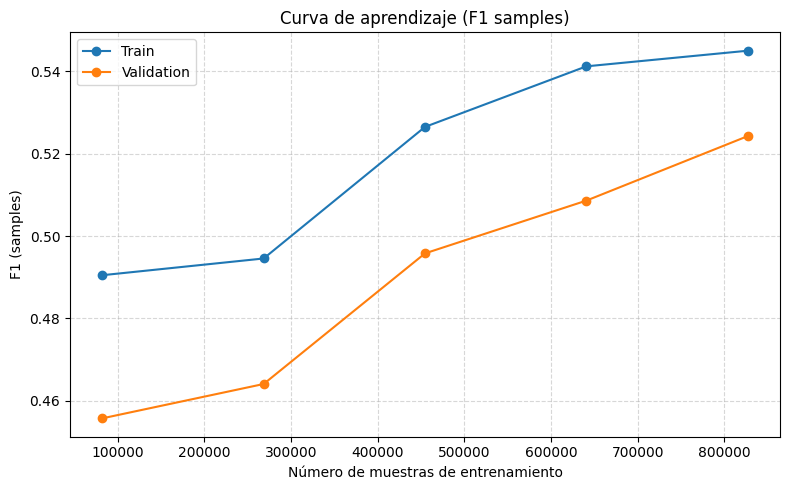

In [2]:
# ——————————————
# plot de la curva de aprendizaje de SVM
# ——————————————
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_abs, train_mean, marker='o', label='Train')
plt.plot(train_sizes_abs, val_mean,   marker='o', label='Validation')
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('F1 (samples)')
plt.title('Curva de aprendizaje (F1 samples)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()